# K-Anonymity of a numerical quasi-identifier using a real-world AI generated dataset from: https://www.kaggle.com/datasets/ohinhaque/ocd-patient-dataset-demographics-and-clinical-data/

In [2]:
import pandas as pd
import random

def anonymize_multidim(data, qis, k):
    assert isinstance(data, pd.DataFrame), "Data must be a Pandas dataframe"
    assert isinstance(k, int) and k > 1, "k must be an integer bigger than 1"
    assert all(qi in data.columns for qi in qis), "All QIs must be columns in the data"

    def mondrian(data, qis, k):
        partition = []

        if len(data) <= (2 * k - 1):
            partition.append(data)
            return [data]

        # Select QI to partition
        qi = select_qi_for_partition(data, qis)

        # Sort data by QI
        data = data.sort_values(by=qi)

        # Number of total values
        si = data[qi].count()
        mid = si // 2

        # Split data
        lhs = data[:mid]
        rhs = data[mid:]

        partition.extend(mondrian(lhs, qis, k))
        partition.extend(mondrian(rhs, qis, k))

        return partition
    
    def select_qi_for_partition(data, qis):
        return qis[0]  # Simple example, can be updated

    result_partitions = mondrian(data, qis, k)

    # Anonymize
    result_final = []

    for partition in result_partitions:
        anonymized_partition = partition.copy()
        for qi in qis:
            part_min = partition[qi].min()
            part_max = partition[qi].max()
            anonymized_partition[qi] = f"[{part_min} - {part_max}]"
        result_final.append(anonymized_partition)

    anonymized = pd.concat(result_final)
    
    return anonymized


In [3]:
# Import dataset
df = pd.read_csv("ocd_patient_dataset.csv")
df = df[["Age", "Y-BOCS Score (Obsessions)", "Y-BOCS Score (Compulsions)"]]

In [4]:
columns_to_anonymize = ["Age"]

df_anonymized = anonymize_multidim(df, columns_to_anonymize, 20)
df_anonymized.head(5)

,Age,Y-BOCS Score (Obsessions),Y-BOCS Score (Compulsions)
1499,[18 - 18],22,34
1459,[18 - 18],16,31
670,[18 - 18],11,0
1451,[18 - 18],30,16
922,[18 - 18],28,26


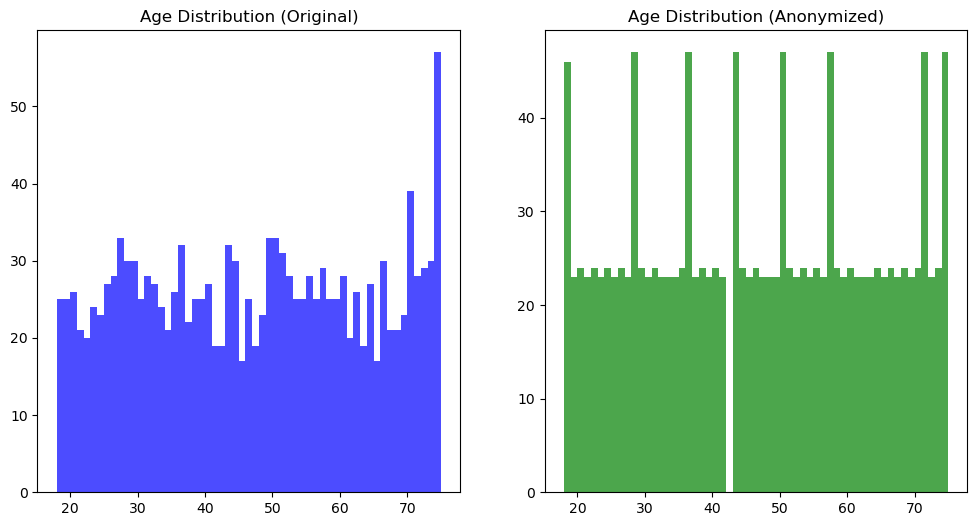

(count    1500.000000
 mean       46.781333
 std        16.830321
 min        18.000000
 25%        32.000000
 50%        47.000000
 75%        61.000000
 max        75.000000
 Name: Age, dtype: float64,
 count    1500.000000
 mean       46.681667
 std        16.877689
 min        18.000000
 25%        32.250000
 50%        47.000000
 75%        60.750000
 max        75.000000
 Name: Age_Midpoint, dtype: float64)

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def extract_midpoint(range_str):
    # Calculate the mean of the range in string format
    return np.mean(list(map(int, range_str.strip('[]').split(' - '))))

# Extract the midpoint for each anonymized column
for column in columns_to_anonymize:
    df_anonymized[f'{column}_Midpoint'] = df_anonymized[column].apply(extract_midpoint)

# Create figures to compare distributions
# Modificado para crear solo un conjunto de 1 fila y 2 columnas
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Age Distribution in Original Data
axes[0].hist(df['Age'], bins=range(df['Age'].min(), df['Age'].max() + 1), alpha=0.7, color='blue')
axes[0].set_title('Age Distribution (Original)')

# Age Distribution in Anonymized Data
axes[1].hist(df_anonymized['Age_Midpoint'], bins=range(int(df_anonymized['Age_Midpoint'].min()), int(df_anonymized['Age_Midpoint'].max()) + 1), alpha=0.7, color='green')
axes[1].set_title('Age Distribution (Anonymized)')

plt.show()

# Calculate and compare summary metrics
summary_original_age = df['Age'].describe()
summary_anonymized_age = df_anonymized['Age_Midpoint'].describe()

(summary_original_age, summary_anonymized_age)


In [11]:
# Calculate the percentage error for mean
original_age_mean = summary_original_age[1]
anonymized_age_mean = summary_anonymized_age[1]
percentage_error_mean = abs((original_age_mean - anonymized_age_mean) / original_age_mean) * 100

# Calculate the percentage error for standard deviation
original_age_std = summary_original_age[2]
anonymized_age_std = summary_anonymized_age[2]
percentage_error_std = abs((original_age_std - anonymized_age_std) / original_age_std) * 100

# Print the results
print("Percentage Error for mean:", percentage_error_mean, "%")
print("Percentage Error for standard deviation:", percentage_error_std, "%")

Percentage Error for mean: 0.21304793934903785 %
Percentage Error for standard deviation: 0.28144956369022006 %
